# Finding the best location for a vegan restaurant in Los Angeles
## Introduction/Business Problem
A vegan diet is being adopted by more and more people in the USA, and the demand for vegan restaurants is correspondingly increasing. This is particularly true in large multicultural cities such as Los Angeles. Hence, this capstone project is tailored to stakeholders who are interested in opening a vegan restaurant in Los Angeles.
We want to use data to answer the following question: What is the best location to open a vegan restaurant in LA? 
## Data sources
Using the Foursquare API (https://developer.foursquare.com/places) we can retrieve information about restaurants in Los Angeles, including location, neighbourhood characteristics (e.g. other venues that are within walking distance), rating, number of tips and type of cuisine. In addition, we will use the Yelp API (https://www.yelp.com/fusion) to find "vegan" venues, because the Foursquare category system only returns a few venues categorized as "vegetarian / vegan", even though there are hundreds according to Yelp or the HappyCow App. To map out districts in Los Angeles we can scrape borough names from Wikipedia and use the geocoder python package to find corresponding geospatial coordinates. Using these coordinates we can search on Foursquare and Yelp to find surrounding venues, including vegan restaurants. 
For example, we can search for venues in Hollywood in Los Angeles using the explore Foursquare querry and find the surrounding venues and their characteristics. Based on the surrounding area characteristics (e.g. lots of food venues or close proximity to metro stations), we can predict vegan restaurant success as measured by both user ratings and number of tips (suggesting that the restaurant is popular). 
Finally, we can predict the best locations to open a new vegan restaurant based on those area characteristics. 


## Methodology
We will start by scraping Los Angeles neighborhood names from the LA-times website and obtain geospatial coordinates using the geopy package. Following this, we will find vegan venues surrounding these coordinates using the Yelp API. Subsequently, we can find the same venues on Foursquare to obtain rating, pricing, tipping, photo and likes information. We will explore which of these factors are useful to keep for further analysis and combine into a useful "popularity and success" dependent variable. Next, we will predict restaurant "popularity and success" using a k-nearest neighbor algorithm with the following independent variables, which characterize a venue's surroundings: 1.) Proximity to public transport, 2.) Number of other food venues nearby, 3.) Number of other vegan food venues nearby, 4.) Number of entertainment venues nearby. 

### Import libraries

In [1]:
## import libraries
import requests

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import geocoder # import geocoder to get latitude and longitude
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules + seaborn
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Setup for foursquare API calls

In [2]:
## Define foursquare credentials and version (date)
CLIENT_ID = 'U1ALKNVSQ5OT5GCDQTE3NTUSVQVANLLFPZBOW3BMYR53AG20' # your Foursquare ID
CLIENT_SECRET = '2BGUAXJ14CEJNJQHSWRLNGA5IOJCMBSOAENHD5INTJOHLP45' # your Foursquare Secret
VERSION = '20200120'
LIMIT = 50
categoryID = "4d4b7105d754a06374d81259" # food category
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U1ALKNVSQ5OT5GCDQTE3NTUSVQVANLLFPZBOW3BMYR53AG20
CLIENT_SECRET:2BGUAXJ14CEJNJQHSWRLNGA5IOJCMBSOAENHD5INTJOHLP45


### Step 1: Scrape city data from website to get LA neighborhoods

In [3]:
url = 'https://maps.latimes.com/neighborhoods/neighborhood/list/'
html = requests.get(url).content
df_list = pd.read_html(html)
df_neigh = df_list[0]
df_neigh.to_csv('LA_borough_data.csv')
df_neigh.head()

,Name,Region
0,Acton,Antelope Valley
1,Adams-Normandie,South L.A.
2,Agoura Hills,Santa Monica Mountains
3,Agua Dulce,Northwest County
4,Alhambra,San Gabriel Valley


#### Get latitude and longitude for each borough in LA using the geopy package


In [4]:
addresses = df_neigh['Name'] + ', ' + 'Los Angeles'
latitudes = [None] * len(addresses)
longitudes = [None] * len(addresses)
lost_cities = list()
for i in range(len(addresses)):
    address = addresses[i] # + ', Los Angeles'
    geolocator = Nominatim(user_agent="random_app_name")
    loc = geolocator.geocode(address, timeout=10)
    if loc:
        lat = loc.latitude
        lng = loc.longitude
        latitudes[i] = lat
        longitudes[i] = lng
        if (i % 10 == 0 and i < 100) or i % 100 == 0 or i == (len(addresses)-1):
            print('{}: The geograpical coordinates of {} are {}, {}.'.format(i, address, lat, lng))
    else:
        latitudes[i] = float('NaN')
        longitudes[i] = float('NaN')
        lost_cities.append(address)
        print('The geograpical coordinates of {} are not available.'.format(address))

0: The geograpical coordinates of Acton, Los Angeles are 34.48074149999999, -118.1868378638664.
10: The geograpical coordinates of Arlington Heights, Los Angeles are 34.1281125, -118.1589035.
20: The geograpical coordinates of Bell, Los Angeles are 33.9747806, -118.1866361.
The geograpical coordinates of Beverly Crest, Los Angeles are not available.
The geograpical coordinates of Broadway-Manchester, Los Angeles are not available.
The geograpical coordinates of Castaic Canyons, Los Angeles are not available.
40: The geograpical coordinates of Cerritos, Los Angeles are 33.8644291, -118.0539323.
The geograpical coordinates of Chesterfield Square, Los Angeles are not available.
50: The geograpical coordinates of Compton, Los Angeles are 33.894927, -118.226624.
60: The geograpical coordinates of Downtown, Los Angeles are 34.4987133, -118.5843067.
The geograpical coordinates of Elizabeth Lake, Los Angeles are not available.
80: The geograpical coordinates of Florence-Firestone, Los Angeles 

#### Clean up location data of neighborhoods (sometimes no location is found or the wrong one is returned, those need to be excluded or fixed)

In [5]:
## New data frame containing all boroughs in LA and their geospatial coordinates
df_neigh['lat'] = latitudes
df_neigh['lng'] = longitudes
df_neigh.head()

,Name,Region,lat,lng
0,Acton,Antelope Valley,34.480741,-118.186838
1,Adams-Normandie,South L.A.,34.033081,-118.297115
2,Agoura Hills,Santa Monica Mountains,34.147910,-118.765704
3,Agua Dulce,Northwest County,34.496382,-118.325635
4,Alhambra,San Gabriel Valley,34.093042,-118.127060


In [6]:
# drop nans from dataframe
df_neigh.dropna(inplace = True)

##### create world map to visualize potentially wrong location data

In [7]:
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, borough in zip(df_neigh['lat'], df_neigh['lng'], df_neigh['Region']):
    label = 'lat={}, lng={}'.format(lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

In [8]:
## Delete everything outside main LA
region_outside_city = ['Northwest County', 'Antelope Valley', 'Harbor', 'Santa Monica Mountains', 'Angeles Forest']
df_neigh.drop(df_neigh[df_neigh['Region'].isin(region_outside_city)].index, inplace = True)
lowest_lat = 33.7483311
largest_lat = 34.3076252
lowest_lng = -118.645476
largest_lng = -117.7166745
df_neigh.drop(df_neigh[(df_neigh['lat'] < lowest_lat) | (df_neigh['lat'] > largest_lat) | (df_neigh['lng'] < lowest_lng) | (df_neigh['lng'] > largest_lat)].index, inplace = True)

In [9]:
df_neigh.head()

,Name,Region,lat,lng
1,Adams-Normandie,South L.A.,34.033081,-118.297115
4,Alhambra,San Gabriel Valley,34.093042,-118.127060
5,Alondra Park,South Bay,33.890134,-118.335133
6,Altadena,Verdugos,34.186316,-118.135233
8,Arcadia,San Gabriel Valley,34.136207,-118.040150


In [10]:
## Just in case get rid of any duplicate Names
df_neigh.drop_duplicates(subset="Name", keep="last", inplace=True)
len(df_neigh)

207

In [11]:
## reset index
df_neigh.reset_index(drop = True, inplace = True)

In [12]:
# create map of LA using latitude and longitude values
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df_neigh['lat'], df_neigh['lng'], df_neigh['Name']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

### Create a function that searches for the 50 closest food venues for each neighborhood in LA

In [13]:
def getNearbyFoodVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT, 
            categoryID)
            
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['venues']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['id'],
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['shortName']) for v in results])
        except:
            ""

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get venues for each neighborhood

In [15]:
df_neigh.head()

,Name,Region,lat,lng
0,Adams-Normandie,South L.A.,34.033081,-118.297115
1,Alhambra,San Gabriel Valley,34.093042,-118.127060
2,Alondra Park,South Bay,33.890134,-118.335133
3,Altadena,Verdugos,34.186316,-118.135233
4,Arcadia,San Gabriel Valley,34.136207,-118.040150


### Let's get vegan restaurants in LA from Yelp (foursquare does not seem to be that great in labelling vegan restaurants...)

In [16]:
radius = 500

## Yelp API access information
CLIENT_ID_YELP = "3gY1EbFOTv7dL5LoTl3y9A"
API_KEY_YELP = "M6O9t1EBUhPmVHlkXUE3ky-SnKektvQZp-m7C5Kd0WBPgfL7uEz6yBD8xC-Q25EqZ82o9ePSz3iK_roowvc-cSCAVgG0WSTz7Wat8zkM6W0ikSROVxKiQ-CDoGskXnYx"

headers = {'Authorization': 'Bearer %s' % API_KEY_YELP}

# In the dictionary, term can take values like food, cafes or businesses like McDonalds
url = 'https://api.yelp.com/v3/businesses/search'
params = {'term':'vegan food','latitude':df_neigh['lat'][1], 'longitude':df_neigh['lng'][1], 'radius':radius, 'categories':['food'], 'limit': 50}

# Making a get request to the API
req=requests.get(url, params=params, headers=headers)
 
# proceed only if the status code is 200
print('The status code is {}'.format(req.status_code))

The status code is 200


In [17]:
def getNearbyFoodVenuesYelp(names, latitudes, longitudes, radius=500, categories=['food']):
    
    venues_list=[]
    headers = {'Authorization': 'Bearer %s' % API_KEY_YELP}
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.yelp.com/v3/businesses/search'
        params = {'term':'vegan food','latitude':lat, 'longitude':lng, 'radius':radius, 'categories':categories, 'limit': 50}
            
        # Making a get request to the API
        req=requests.get(url, params=params, headers=headers)
        
        # if successful
        if req.status_code == 200:
            
            # convert data into JSON object
            results = json.loads(req.text)['businesses']
            
            # return only relevant information for each nearby venue
            try: # sometimes "price" category is missing, then simply include empty string
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['id'],
                    v['coordinates']['latitude'], 
                    v['coordinates']['longitude'],  
                    'vegan', 
                    v['rating'], 
                    v['price']) for v in results])
            except:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['id'],
                    v['coordinates']['latitude'], 
                    v['coordinates']['longitude'],  
                    'vegan', 
                    v['rating'], 
                    '') for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category', 
                  'Rating', 
                  'Price tier']
    
    return(nearby_venues)

In [18]:
LA_venues_YELP = getNearbyFoodVenuesYelp(names=df_neigh['Name'], latitudes=df_neigh['lat'], longitudes=df_neigh['lng'])

Adams-Normandie
Alhambra
Alondra Park
Altadena
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bellflower
Bell Gardens
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Burbank
Canoga Park
Carthay
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Diamond Bar
Downey
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy Park
Granada Hills
Griffith Park
Hacienda Heights
Hancock Park
Hansen Dam
Harvard Heights
Hawthorne
Hermosa Beach
Highland Park
Hollywood
Hollywood Hills
Hollywood Hills West
Huntington Park
Hyde Park
Industry
Inglewood
Irw

##### Drop locations that were found multiple times

In [19]:
LA_venues_YELP.drop_duplicates(subset='Venue', keep="first", inplace=True)

#### Go through vegan venues found on yelp and see if we can find it also on foursquare. 

In [20]:
## This way we can get a consistent cuisine labelling (from foursquare), while the vegan label
## comes from Yelp. It is also useful to get foursquare venue IDs to look up details about venues later (e.g. pricing or number of likes).
yelp_venue_category = list()
fs_venue_ids = list()
for name, lat, lng in zip(LA_venues_YELP['Venue'], LA_venues_YELP['Venue Latitude'], LA_venues_YELP['Venue Longitude']):
    print(name)

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        100, 
        1,
        "4d4b7105d754a06374d81259") # only look at food categories

    # make the GET request
    try:
        results = requests.get(url).json()["response"]['venues'][0]
        fs_venue_category =  results['categories'][0]['shortName']       
        fs_venue_id = results['id']
    except:
        fs_venue_category = ""
        fs_venue_id = ""
    #print('-->' + fs_venue_category)
    
    yelp_venue_category.append(fs_venue_category)
    fs_venue_ids.append(fs_venue_id)

Lovebirds Cafe
Alhambra Farmers Market
Sprouts Farmers Market
Bon Appetea Cafe
Robeks
7 Leaves Cafe
Afters Ice Cream
Tastea
Oh Happy Days Natural Food Grocery and Cafe
Tacos 210
Dina's Dumpling
Grocery Outlet Bargain Market
Café de Leche
Chinese Laundry Catering
The Gooey Gourmet
Aldi
LA Paella Catering
GOT PAELLA
Brady's Bakery
Chinese Laundry
GermanYumTruck
The Lobos Truck
Sus Arepas
Roobina's Cake
The Truck Stop
Ozzies Street Tacos
Out West Catering
Chef C's Smhokin Pot
Cítrico Ceviche Bar
Maravilla Latin Cuisine
Tacos La Tehuanita
The Churro Man
Okamoto Kitchen
Good Life Organics
The Bollywood Kitchen
Two Doughs Pizza Co
Teddy's Red Tacos
Chili Chili Mango
Madison Rose Bakery
Tokyo Style Food Truck and Catering
Hungry Belly
Chingón Catering
The Grilled Cheese Truck
The Lime Truck
Lucca Truck
Simply Eggless Bakery - Délicieux
Meccha Matcha
The Cake Korner
Heartland
Pioneer Cash And Carry
Nice Bakery
Lee's Sandwiches
Ambala Sweets & Snacks
99 Ranch Market
GoodFellas Taco Catering
Yog

Sweetness Cakes & Cafe
Punjab Indian Market and Cuisine
Bopomofo Cafe
Mitsuwa Marketplace
Labobatory
Swirlz Creamery
D'ange Bakery
Nomad Ice Pops
Fortune Bakery
Factory Tea Bar
Yama Seafood
Garnish Cafe
Sweet & Savory
Swirlz Soft Serve Parlor
SuperFood Cafe
Backyard Bowls
Kreation Organic Kafe
Sidecar Doughnuts & Coffee
Caffe Luxxe
Holy Grounds at St. Monica
Huckleberry
Planet Smoothie and Tasti D-Lite
Santa Monica Seafood Market & Cafe
John Kelly Chocolates
7-Eleven
India Jones Chow Truck
The Greasy Wiener
Ralph's
Happy Days Cafe
Ubatuba Acai X - Sherman Oaks
Juice Crafters
QWENCH juice bar
Paradis Sherman Oaks
The Dolly Llama
New York Bagel Cafe
Juice Budz
Gelson's
Humphrey Yogart
SanSai Japanese Grill
Syndicate
Evil Cooks
Coffee.jpg
Bean Town
Yogurt & More
Taylor's Ol’ Fashioned Market
Mother Moo Creamery
The Four Seasons Tea Room
Botanica Restaurant & Market
Lamill Coffee Silverlake
Milk
Lucky
barcito
Nimbus Coffee
illy Caffè
Groundwork Coffee
Red Mango
Dogtown Dogs Truck
Grassroot

In [21]:
LA_venues_YELP['Venue Category'] = yelp_venue_category
LA_venues_YELP['FS Venue ID'] = fs_venue_ids

In [22]:
LA_venues_YELP['Venue Category'].value_counts()

Coffee Shop           107
                       57
Café                   34
Bakery                 27
Mexican                22
Chinese                20
American               17
Food Truck             17
Deli / Bodega          17
Pizza                  16
Fast Food              15
Restaurant             14
Bubble Tea             14
Diner                  14
Asian                  13
Gastropub              13
Ice Cream              12
New American           10
Breakfast              10
Sandwiches              9
Bookstore               9
Italian                 8
Seafood                 8
Donuts                  7
Tacos                   6
Gourmet                 6
Sushi                   6
Burgers                 6
Vegetarian / Vegan      5
Japanese                5
Korean                  5
Supermarket             5
Mediterranean           5
BBQ                     5
Vietnamese              4
German                  4
Indonesian              4
Indian                  3
Grocery Stor

In [23]:
categories_to_kick_out = ["", "Deli / Bodega", "Arcade", "Hot Dogs", "Entertainment", "Sports Bar", "Bar", "Gas Station", "Bookstore", "Yogurt", "Fried Chicken", 
                          "Brewery", "Pharmacy", "Desserts", "Grocery Store", "Cineplex", "Juice Bar", "Steakhouse", "Ice Cream", "Supermarket", "Bubble Tea", "Bakery"]

In [24]:
indexNames = LA_venues_YELP[ LA_venues_YELP['Venue Category'].isin(categories_to_kick_out) ].index
print(indexNames)
# Delete these row indexes from dataFrame
LA_venues_YELP.drop(indexNames , inplace=True)

Int64Index([   7,    9,   13,   14,   18,   20,   28,   29,   34,   38,
            ...
            1910, 1934, 1937, 1946, 1959, 2011, 2014, 2030, 2085, 2138],
           dtype='int64', length=164)


In [25]:
LA_venues_YELP['Venue Category'][LA_venues_YELP['Venue Category'] == 'Café'] = 'Coffee Shop'

C:\Users\sbuer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
# Delete categories of little to no interest for opening a vegan restaurant (e.g. we do not compete with a supermarket)
LA_venues_YELP['Venue Category'].value_counts()

Coffee Shop           141
Mexican                22
Chinese                20
American               17
Food Truck             17
Pizza                  16
Fast Food              15
Restaurant             14
Diner                  14
Asian                  13
Gastropub              13
Breakfast              10
New American           10
Sandwiches              9
Seafood                 8
Italian                 8
Donuts                  7
Sushi                   6
Gourmet                 6
Tacos                   6
Burgers                 6
Korean                  5
Vegetarian / Vegan      5
Japanese                5
BBQ                     5
Mediterranean           5
German                  4
Indonesian              4
Vietnamese              4
Indian                  3
Dim Sum                 3
Food Court              3
Taiwanese               3
Bagels                  3
Food                    3
Irish                   2
Snacks                  2
Caribbean               2
French      

In [27]:
supermarkets = ["7-Eleven", "Aldi"]
LA_venues_YELP.drop(LA_venues_YELP[LA_venues_YELP['Venue'].isin(supermarkets)].index, inplace=True)

In [28]:
venue_counts_yelp = LA_venues_YELP.groupby('Neighborhood').count()
venue_counts_yelp.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price tier,FS Venue ID
Neighborhood,,,,,,,,,,
Alhambra,7,7,7,7,7,7,7,7,7,7
Altadena,14,14,14,14,14,14,14,14,14,14
Arleta,8,8,8,8,8,8,8,8,8,8
Artesia,23,23,23,23,23,23,23,23,23,23
Atwater Village,2,2,2,2,2,2,2,2,2,2


#### Visualize Yelp vegan restaurant data

In [29]:
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(LA_venues_YELP['Venue Latitude'], LA_venues_YELP['Venue Longitude'], LA_venues_YELP['Venue']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

#### Set boundaries for vegan venues - only those in LA are of interest!

In [30]:
print(df_neigh.lng[df_neigh['Name']=="Pacific Palisades"])
print(df_neigh.lng[df_neigh['Name']=="Glendora"])
print(df_neigh.lat[df_neigh['Name']=="San Fernando"])
print(df_neigh.lat[df_neigh['Name']=="Bellflower"])

123   -118.540955
Name: lng, dtype: float64
67   -117.865339
Name: lng, dtype: float64
146    34.28497
Name: lat, dtype: float64
16    33.88257
Name: lat, dtype: float64


In [31]:
## Create a backup of the LA_venues_YELP dataframe
YELP_bu = LA_venues_YELP

In [32]:
## Delete Yelp restaurants outside LA (Yelp increases the radius up to 25km to fill up the 50 requested return slots)
lowest_lat = 33.88257
largest_lat = 34.28497
lowest_lng = -118.540955
largest_lng = -117.865339
LA_venues_YELP.drop(LA_venues_YELP[(LA_venues_YELP['Venue Latitude'] < lowest_lat) | 
                                   (LA_venues_YELP['Venue Latitude'] > largest_lat) | 
                                   (LA_venues_YELP['Venue Longitude'] < lowest_lng) | 
                                   (LA_venues_YELP['Venue Longitude'] > largest_lng)
                                  ].index, inplace = True)

In [33]:
## Visualize Yelp vegan restaurant data
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(LA_venues_YELP['Venue Latitude'], LA_venues_YELP['Venue Longitude'], LA_venues_YELP['Venue']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

In [34]:
LA_venues_YELP.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price tier,FS Venue ID
0,Alhambra,34.093042,-118.12706,Lovebirds Cafe,0KeC2ioM5HM4VOHimzQrlA,34.094326,-118.127487,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca
1,Alhambra,34.093042,-118.12706,Alhambra Farmers Market,K2Lf7yWTll38m-r-A_7ohw,34.093122,-118.128167,Coffee Shop,4.0,$$,53bb56c3498e1eb378326cae
2,Alhambra,34.093042,-118.12706,Sprouts Farmers Market,-tX_rTfxcCV0dhx0hge6DA,34.095342,-118.125038,Burgers,3.5,$$,55fc485d498e81836932d7fe
3,Alhambra,34.093042,-118.12706,Bon Appetea Cafe,2xOKFfMqj3WRrxwZUJNRlw,34.093921,-118.128958,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca
4,Alhambra,34.093042,-118.12706,Robeks,0qeuPidgfBedF4DOcYoQ4w,34.095222,-118.127198,Coffee Shop,3.5,$,4aca3687f964a520e4c020e3


#### Let's find out how many unique categories can be curated from all the returned venues

In [35]:
LA_venues_YELP.shape

(404, 11)

In [36]:
## keep a dataframe with only vegan restaurants
LA_vegan_venues = LA_venues_YELP
LA_vegan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price tier,FS Venue ID
0,Alhambra,34.093042,-118.12706,Lovebirds Cafe,0KeC2ioM5HM4VOHimzQrlA,34.094326,-118.127487,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca
1,Alhambra,34.093042,-118.12706,Alhambra Farmers Market,K2Lf7yWTll38m-r-A_7ohw,34.093122,-118.128167,Coffee Shop,4.0,$$,53bb56c3498e1eb378326cae
2,Alhambra,34.093042,-118.12706,Sprouts Farmers Market,-tX_rTfxcCV0dhx0hge6DA,34.095342,-118.125038,Burgers,3.5,$$,55fc485d498e81836932d7fe
3,Alhambra,34.093042,-118.12706,Bon Appetea Cafe,2xOKFfMqj3WRrxwZUJNRlw,34.093921,-118.128958,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca
4,Alhambra,34.093042,-118.12706,Robeks,0qeuPidgfBedF4DOcYoQ4w,34.095222,-118.127198,Coffee Shop,3.5,$,4aca3687f964a520e4c020e3


In [37]:
## Treating all vegan restaurants equally for now, let's explore ratings ... 
# create map 
latitude = 34.0330812
longitude = -118.204865
map_LA_veg_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
df = LA_vegan_venues
for lat, lng, venue, rating in zip(df['Venue Latitude'], df['Venue Longitude'], df['Venue'], df['Rating']):
    if rating > 4.5:
        cur_col = 'green'
    elif rating >= 4.5:
        cur_col = '#73cd32'#cdb332
    elif rating >= 4:
        cur_col = '#9acd32'
    elif rating >= 3.5:
        cur_col = '#c1cd32'
    elif rating >= 3:
        cur_col = 'orange'
    else:
        cur_col = 'red'
    label = '{}'.format(venue)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=folium.Popup(label, parse_html=True),
        color=cur_col,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_veg_venues)  
    
map_LA_veg_venues

In [38]:
## Group some categories together and delete certain unclear categories
unclear_categories = ["Park", "Mall", "Halal", "Food Stand", "Farmer's Market", "Food", "Donuts"]
LA_vegan_venues.drop(LA_vegan_venues[LA_vegan_venues["Venue Category"].isin(unclear_categories)].index, inplace=True)

## Cafe and Coffee Shop are the same!
LA_vegan_venues["Venue Category"][LA_vegan_venues["Venue Category"] == "Café"] = "Coffee Shop"

C:\Users\sbuer\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


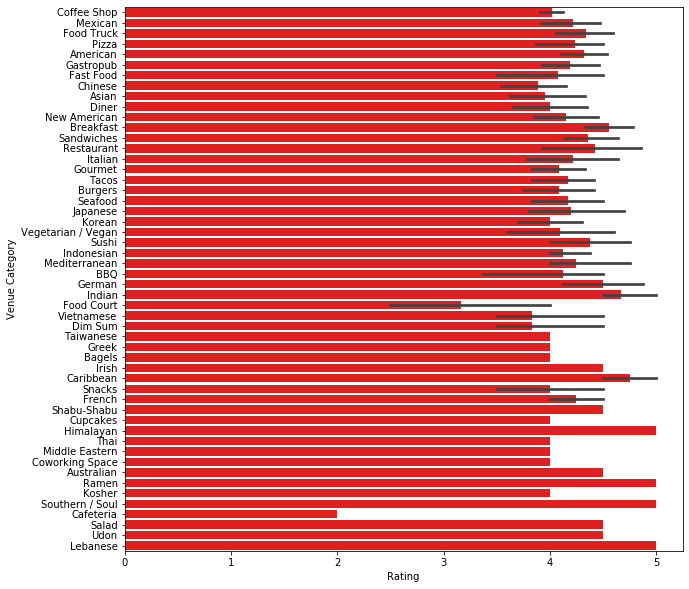

In [39]:
## What food categories are particulary popular/highly rated?
plt.figure(figsize=(10,10))
sns.barplot(
    data=LA_vegan_venues,
    x="Rating", 
    y="Venue Category",
    color='red', 
    order=LA_vegan_venues['Venue Category'].value_counts().index)

#### For each vegan restaurant get pricing, likes, photos, tips and rating (if they exists on Foursquare)

In [40]:
like_list = list()
price_list = list()
photos_list = list()
tips_list = list()
rating_list = list()

for irest in range(len(LA_vegan_venues['FS Venue ID'])):

    venue_id = LA_vegan_venues['FS Venue ID'][LA_vegan_venues['FS Venue ID'].index[irest]]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/'+venue_id+'?/&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)

    # make the GET request
    result = requests.get(url).json()["response"]    

    # Get likes and pricing (if available), otherwise append empty list
    likes = []
    price = []
    photos = []
    tips = []
    rating = []
    if len(result) != 0: # if result is empty do nothing
        try:
            likes = result['venue']['likes']['count']
        except:
            ""
        try:
            price = result['venue']['price']['tier']
        except:
            ""
        try:
            photos = result['venue']['photos']['count'] 
        except:
            ""
        try:
            tips = result['venue']['tips']['count'] 
        except:
            ""
        try:
            rating = result['venue']['rating'] 
        except:
            ""
        
    like_list.append(likes)
    price_list.append(price)
    photos_list.append(photos)
    tips_list.append(tips)
    rating_list.append(rating)

In [41]:
LA_vegan_venues.shape

(394, 11)

In [ ]:
#price_list = price_list_bu
#like_list = like_list_bu
#photos_list = photos_list_bu
#tips_list = tips_list_bu
#rating_list = rating_list_bu

In [46]:
#price_list_bu = price_list
#like_list_bu = like_list
#photos_list_bu = photos_list
#tips_list_bu = tips_list
#rating_list_bu = rating_list

In [42]:
len(like_list)

394

In [43]:
LA_vegan_venues['Price FS'] = price_list
LA_vegan_venues['Likes FS'] = like_list
LA_vegan_venues['Photos FS'] = photos_list
LA_vegan_venues['Tips FS'] = tips_list
LA_vegan_venues['Rating FS'] = rating_list

In [49]:
## Save vegan dataset 
#LA_vegan_venues.to_csv('LA_vegan_venues.csv')

In [67]:
#LA_vegan_venues = pd.read_csv("LA_vegan_venues.csv")

##### Replace empty list elements with NaNs

In [44]:
LA_vegan_venues.mask(LA_vegan_venues.applymap(str).eq('[]'), inplace=True)
LA_vegan_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price tier,FS Venue ID,Price FS,Likes FS,Photos FS,Tips FS,Rating FS
0,Alhambra,34.093042,-118.12706,Lovebirds Cafe,0KeC2ioM5HM4VOHimzQrlA,34.094326,-118.127487,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca,NaN,2,16,1,NaN
1,Alhambra,34.093042,-118.12706,Alhambra Farmers Market,K2Lf7yWTll38m-r-A_7ohw,34.093122,-118.128167,Coffee Shop,4.0,$$,53bb56c3498e1eb378326cae,1,40,90,20,7.4
2,Alhambra,34.093042,-118.12706,Sprouts Farmers Market,-tX_rTfxcCV0dhx0hge6DA,34.095342,-118.125038,Burgers,3.5,$$,55fc485d498e81836932d7fe,1,22,27,4,7.6
3,Alhambra,34.093042,-118.12706,Bon Appetea Cafe,2xOKFfMqj3WRrxwZUJNRlw,34.093921,-118.128958,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca,NaN,2,16,1,NaN
4,Alhambra,34.093042,-118.12706,Robeks,0qeuPidgfBedF4DOcYoQ4w,34.095222,-118.127198,Coffee Shop,3.5,$,4aca3687f964a520e4c020e3,1,47,61,20,7.3


In [1]:
LA_vegan_venues[["Rating", "Rating FS", "Price FS", "Likes FS", "Tips FS", "Photos FS"]].head(10)

NameError: name 'LA_vegan_venues' is not defined

In [46]:
corr_matrix = LA_vegan_venues[["Rating", "Rating FS", "Price FS", "Likes FS", "Tips FS", "Photos FS"]].apply(pd.to_numeric).corr(method="spearman")
corr_matrix.style.background_gradient(cmap='coolwarm')

,Rating,Rating FS,Price FS,Likes FS,Tips FS,Photos FS
Rating,1,-0.0390468,0.0118588,-0.157255,-0.132114,-0.174267
Rating FS,-0.0390468,1,0.254306,0.61554,0.452065,0.544115
Price FS,0.0118588,0.254306,1,0.406132,0.422209,0.418841
Likes FS,-0.157255,0.61554,0.406132,1,0.947115,0.961489
Tips FS,-0.132114,0.452065,0.422209,0.947115,1,0.917688
Photos FS,-0.174267,0.544115,0.418841,0.961489,0.917688,1


Likes tips and photos are almost perfectly correlated, so I can just keep one of them.
However, Rating and Rating FS are hardly correlated at all, which is surprising. I will stick with only Foursquare information for now.  

#### Plot distributions of variables (rating, likes, etc.)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'log(Likes FS + 0.5)')]

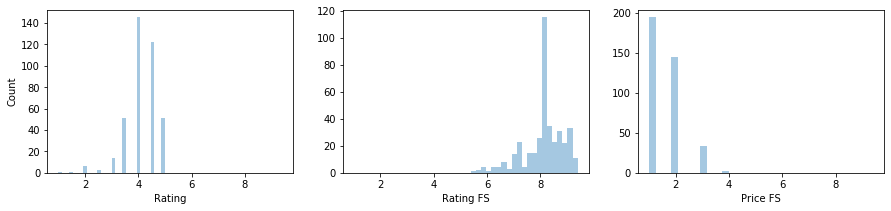

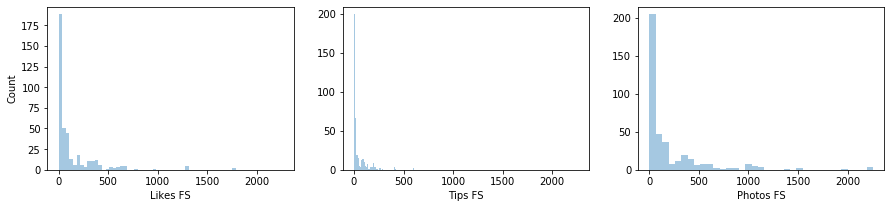

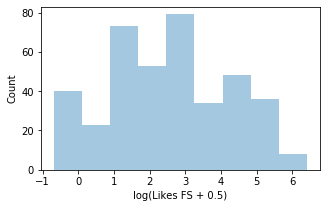

In [129]:
## Is restaurant rating related to surroundings? If so which ones?
## Show pricing by category
fig,a = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
sns.distplot(LA_vegan_venues['Rating'], kde=False, ax=a[0]);
sns.distplot(LA_vegan_venues['Rating FS'], kde=False, ax=a[1]);
sns.distplot(LA_vegan_venues['Price FS'][LA_vegan_venues['Price FS'].notnull()], kde=False, ax=a[2]);
a[0].set(ylabel='Count')
fig2,a2 = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
sns.distplot(LA_vegan_venues['Likes FS'], kde=False, ax=a2[0]);
sns.distplot(LA_vegan_venues['Tips FS'], kde=False, ax=a2[1]);
sns.distplot(LA_vegan_venues['Photos FS'], kde=False, ax=a2[2]);
a2[0].set(ylabel='Count')
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(np.log(LA_vegan_venues['Tips FS']+0.5), kde=False);
a3.set(xlabel='log(Likes FS + 0.5)', ylabel='Count')

In [48]:
## We want to open a restaurant that is popular and successful, which we might quantify by having a high rating, as well as many tips. 
## Because the range of values for likes and rating are so different, we swill first put them in a similar scale and then simply add them up to create our variable of restaurant success. 
## We also need to substitute ratings that are unavailable on FS (let's use the median rating overall)

In [49]:
LA_vegan_venues['Rating FS'][LA_vegan_venues['Rating FS'].isnull()] = np.median(LA_vegan_venues['Rating FS'][LA_vegan_venues['Rating FS'].notnull()])

C:\Users\sbuer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
LA_vegan_venues["success"] = 0.5 * ( (np.log(LA_vegan_venues['Tips FS']+1) / max(np.log(LA_vegan_venues['Tips FS']+1))) + (LA_vegan_venues['Rating FS'] / 10) )

In [51]:
LA_vegan_venues.head(6)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price tier,FS Venue ID,Price FS,Likes FS,Photos FS,Tips FS,Rating FS,success
0,Alhambra,34.093042,-118.12706,Lovebirds Cafe,0KeC2ioM5HM4VOHimzQrlA,34.094326,-118.127487,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca,NaN,2,16,1,8.2,0.464025
1,Alhambra,34.093042,-118.12706,Alhambra Farmers Market,K2Lf7yWTll38m-r-A_7ohw,34.093122,-118.128167,Coffee Shop,4.0,$$,53bb56c3498e1eb378326cae,1,40,90,20,7.4,0.607294
2,Alhambra,34.093042,-118.12706,Sprouts Farmers Market,-tX_rTfxcCV0dhx0hge6DA,34.095342,-118.125038,Burgers,3.5,$$,55fc485d498e81836932d7fe,1,22,27,4,7.6,0.505441
3,Alhambra,34.093042,-118.12706,Bon Appetea Cafe,2xOKFfMqj3WRrxwZUJNRlw,34.093921,-118.128958,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca,NaN,2,16,1,8.2,0.464025
4,Alhambra,34.093042,-118.12706,Robeks,0qeuPidgfBedF4DOcYoQ4w,34.095222,-118.127198,Coffee Shop,3.5,$,4aca3687f964a520e4c020e3,1,47,61,20,7.3,0.602294
5,Alhambra,34.093042,-118.12706,7 Leaves Cafe,IsnuQoc2QRvs0QSU0ZOxEg,34.096550,-118.128250,Coffee Shop,4.0,$,593c61c48c812a1b83486fa7,1,18,44,2,8,0.485627


[Text(0, 0.5, 'Count')]

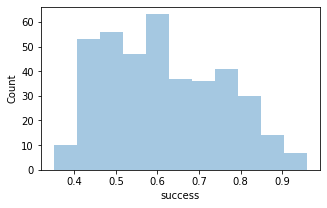

In [52]:
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(LA_vegan_venues['success'], kde=False);
a3.set(ylabel='Count')

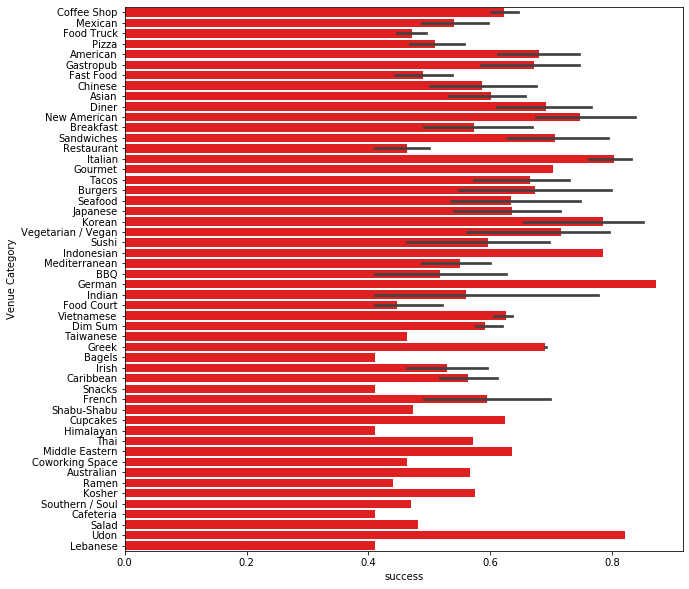

In [53]:
## What food categories are particulary popular/highly rated?
plt.figure(figsize=(10,10))
sns.barplot(
    data=LA_vegan_venues,
    x="success", 
    y="Venue Category",
    color='red', 
    order=LA_vegan_venues['Venue Category'].value_counts().index)

#### Treating the vegan venues as "neighborhoods", we can look on foursquare to find adjacent Venues in a 500 meter radius and then use k-means clustering to find structure

In [54]:
## Group into larger relevant categories
fs_categories = {
    'Food': '4d4b7105d754a06374d81259',
    'Shop & Service': '4d4b7105d754a06378d81259',
    'Bus Stop': '52f2ab2ebcbc57f1066b8b4f',
    'Metro Station': '4bf58dd8d48988d1fd931735',
    'Nightlife Spot': '4d4b7105d754a06376d81259',
    'Arts & Entertainment': '4d4b7104d754a06370d81259'
}
fs_category_labels = ["Food", "Shop & Service", "Bus Stop", "Metro Station", "Nightlife Spot", "Arts & Entertainment"]

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        for icat in range(len(fs_category_labels)):

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                fs_categories[fs_category_labels[icat]])

            # make the GET request
            try: 
                results = requests.get(url).json()["response"]['venues']

                # return only relevant information for each nearby venue
                for v in results:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['id'],
                        v['location']['lat'], 
                        v['location']['lng'],  
                        v['categories'][0]['shortName'], 
                        fs_category_labels[icat])])
            except:
                print("Exception occured - could not read information from Foursquare")
                
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category Detailed', 
                  'Venue Category']

    return(nearby_venues)

In [60]:
surrounding_venues = getNearbyVenues(LA_vegan_venues["Venue"], LA_vegan_venues["Venue Latitude"], LA_vegan_venues["Venue Longitude"])

Lovebirds Cafe
Alhambra Farmers Market
Sprouts Farmers Market
Bon Appetea Cafe
Robeks
7 Leaves Cafe
Afters Ice Cream
Oh Happy Days Natural Food Grocery and Cafe
Dina's Dumpling
Grocery Outlet Bargain Market
Café de Leche
LA Paella Catering
GOT PAELLA
Chinese Laundry
The Lobos Truck
Sus Arepas
Roobina's Cake
The Truck Stop
Chef C's Smhokin Pot
Tacos La Tehuanita
The Churro Man
Okamoto Kitchen
The Bollywood Kitchen
Teddy's Red Tacos
Tokyo Style Food Truck and Catering
Hungry Belly
Chingón Catering
The Falafel Factory
Urban Espresso
Pinch of Flavor
Baby's Badass Burgers
Delmy's Pupusas
Atwater Village Farmers' Market
Yureka Boba & Tea House
Congregation Ale House
Mantra Coffee & BnB
Smart & Final Extra!
King Donut
Acai Joint
Cevicheria Las Olas
Habibi Yalla
Mix Bowl Heroes
La Kubanita
Billionaire Burger Boyz
The F Truck
Poutine Brothers
Fries First
Kings Wings
Amazebowls
Ortiz kitchen on the Street
Los Angeles Shave Ice Truck
Wicked Fish Tacos
Wing Society
Richeeze
Big Green Bowl
Roni Mac

##### Note that the venues themselves will be included in the output. I will leave those in, even though being close to oneself is not very informative, being close to one of the other vegan restaurants might well be!

In [61]:
surrounding_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category Detailed,Venue Category
0,Lovebirds Cafe,34.094326,-118.127487,Love Birds Cafe & Bakery,4a96fc37f964a520d72720e3,34.094307,-118.127587,Bakery,Food
1,Lovebirds Cafe,34.094326,-118.127487,Gen Korean BBQ House,50dd1021e4b04eb763143b28,34.094575,-118.127879,Korean,Food
2,Lovebirds Cafe,34.094326,-118.127487,Starbucks,4aca3687f964a520e4c020e3,34.094775,-118.128113,Coffee Shop,Food
3,Lovebirds Cafe,34.094326,-118.127487,38 Degrees Ale House and Grill,4af39c5cf964a520eeee21e3,34.094512,-118.127912,Gastropub,Food
4,Lovebirds Cafe,34.094326,-118.127487,Afters Ice Cream,58e1c7b4ca107022094178b9,34.094715,-118.127563,Ice Cream,Food


#### Do one hot encoding for different venue types (e.g. food or reachability)

In [62]:
# one hot encoding of venue categories by neighborhood
LA_onehot = pd.get_dummies(surrounding_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Vegan Venue'] = surrounding_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

,Vegan Venue,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service
0,Lovebirds Cafe,0,0,1,0,0,0
1,Lovebirds Cafe,0,0,1,0,0,0
2,Lovebirds Cafe,0,0,1,0,0,0
3,Lovebirds Cafe,0,0,1,0,0,0
4,Lovebirds Cafe,0,0,1,0,0,0


In [63]:
## Data frame showing number of venue category by neighborhood
LA_sum = LA_onehot.groupby('Vegan Venue').sum().reset_index()
LA_sum.head()

,Vegan Venue,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service
0,1802 Roasters,1,0,5,0,0,6
1,7 Leaves Cafe,3,0,42,0,9,25
2,85°C Bakery Cafe,8,0,50,0,34,37
3,A Divine H2O,14,0,30,0,6,38
4,ACASA Food Truck,1,0,2,0,1,0


#### Feature selection

In [67]:
LA_vegan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price tier,FS Venue ID,Price FS,Likes FS,Photos FS,Tips FS,Rating FS,success
0,Alhambra,34.093042,-118.12706,Lovebirds Cafe,0KeC2ioM5HM4VOHimzQrlA,34.094326,-118.127487,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca,NaN,2,16,1,8.2,0.464025
1,Alhambra,34.093042,-118.12706,Alhambra Farmers Market,K2Lf7yWTll38m-r-A_7ohw,34.093122,-118.128167,Coffee Shop,4.0,$$,53bb56c3498e1eb378326cae,1,40,90,20,7.4,0.607294
2,Alhambra,34.093042,-118.12706,Sprouts Farmers Market,-tX_rTfxcCV0dhx0hge6DA,34.095342,-118.125038,Burgers,3.5,$$,55fc485d498e81836932d7fe,1,22,27,4,7.6,0.505441
3,Alhambra,34.093042,-118.12706,Bon Appetea Cafe,2xOKFfMqj3WRrxwZUJNRlw,34.093921,-118.128958,Taiwanese,4.0,$,5d60a20dbde37a0008c34bca,NaN,2,16,1,8.2,0.464025
4,Alhambra,34.093042,-118.12706,Robeks,0qeuPidgfBedF4DOcYoQ4w,34.095222,-118.127198,Coffee Shop,3.5,$,4aca3687f964a520e4c020e3,1,47,61,20,7.3,0.602294


In [77]:
LA_sum.head()

,Vegan Venue,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service,Neighborhood
0,1802 Roasters,1,0,5,0,0,6,Alhambra
1,7 Leaves Cafe,3,0,42,0,9,25,Alhambra
2,85°C Bakery Cafe,8,0,50,0,34,37,Alhambra
3,A Divine H2O,14,0,30,0,6,38,Alhambra
4,ACASA Food Truck,1,0,2,0,1,0,Alhambra


In [115]:
## Features (independent variables)
X = LA_sum[fs_category_labels]

## And dependent variable (restaurant success / popularity)
y = LA_vegan_venues['success'].astype('float')

#### Divide data into training and test set

In [116]:
from sklearn.model_selection import train_test_split

# divide data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

# this last bit is just to check whether I get the same answer with the standardscaler method (see below)
X_test_z_manual = (X_test - X_train.mean()) / np.std(X_train)
X_test_z_manual[0:5]

,Food,Shop & Service,Bus Stop,Metro Station,Nightlife Spot,Arts & Entertainment
252,0.107100,0.959453,-0.355233,-0.201745,-0.249092,-0.786206
153,0.898685,0.815999,0.874061,-0.201745,0.515204,0.513619
390,0.502893,0.313909,-0.355233,-0.201745,-0.030721,-0.186287
285,0.304996,1.102907,-0.355233,-0.201745,1.170315,0.413633
381,0.107100,1.246362,0.874061,-0.201745,0.187649,0.413633


In [117]:
Xz_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
Xz_test = preprocessing.StandardScaler().fit(X_train).transform(X_test)
Xz_test[0:5]

array([[ 0.10709982,  0.95945292, -0.35523328, -0.20174479, -0.24909156,
        -0.78620609],
       [ 0.89868535,  0.81599862,  0.87406084, -0.20174479,  0.51520439,
         0.51361916],
       [ 0.50289258,  0.31390856, -0.35523328, -0.20174479, -0.03072129,
        -0.18628674],
       [ 0.3049962 ,  1.10290722, -0.35523328, -0.20174479,  1.1703152 ,
         0.4136326 ],
       [ 0.10709982,  1.24636152,  0.87406084, -0.20174479,  0.18764898,
         0.4136326 ]])

#### K-nearest neighbor classification

In [133]:
## get required package
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 

rmse_val = [] #to store rmse values for different k
Nk = 20
for K in range(Nk):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(Xz_train, y_train)  #fit the model
    pred=model.predict(Xz_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.20183357320341358
RMSE value for k=  2 is: 0.17655623484825753
RMSE value for k=  3 is: 0.1697759984493741
RMSE value for k=  4 is: 0.16563080309154596
RMSE value for k=  5 is: 0.16243071615201288
RMSE value for k=  6 is: 0.16367317633118186
RMSE value for k=  7 is: 0.16065955971539694
RMSE value for k=  8 is: 0.1593610171493909
RMSE value for k=  9 is: 0.1574688524562296
RMSE value for k=  10 is: 0.15700006243249232
RMSE value for k=  11 is: 0.15636687588228657
RMSE value for k=  12 is: 0.15644097866414175
RMSE value for k=  13 is: 0.15659917230535664
RMSE value for k=  14 is: 0.15530513813212016
RMSE value for k=  15 is: 0.15489169971506037
RMSE value for k=  16 is: 0.154209054015244
RMSE value for k=  17 is: 0.1537472590757475
RMSE value for k=  18 is: 0.1540352926846419
RMSE value for k=  19 is: 0.1536031752959693
RMSE value for k=  20 is: 0.15363563234289307


#### Visualize decoding performance (RMSE)


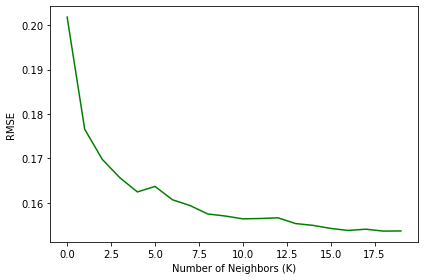

In [134]:
plt.plot(range(Nk),rmse_val,'g')
plt.ylabel('RMSE ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

A value of K = 8 seems reasonable

#### We can now finally go through the different neighborhoods of LA and predict vegan restaurant success based on its characteristics

For each neighborhood, obtain the surrounding venues in a 200 m radius (as we did before centered on the restaurants). In principle this can be done with any specific location, but for now we just want to have a rough idea of which neighborhoods are suitable for opening a vegan restaurant.

In [131]:
LA_neigh_venues = getNearbyVenues(df_neigh["Name"], df_neigh["lat"], df_neigh["lng"])

Adams-Normandie
Alhambra
Alondra Park
Altadena
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bellflower
Bell Gardens
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Burbank
Canoga Park
Carthay
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Diamond Bar
Downey
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy Park
Granada Hills
Griffith Park
Hacienda Heights
Hancock Park
Hansen Dam
Harvard Heights
Hawthorne
Hermosa Beach
Highland Park
Hollywood
Hollywood Hills
Exception occured - could not read information from Foursquare
Hollyw

In [135]:
LA_neigh_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category Detailed,Venue Category
0,Adams-Normandie,34.033081,-118.297115,El Rincon Hondureño,4f3eabbfe4b0a6be6abe004e,34.032527,-118.298860,Latin American,Food
1,Adams-Normandie,34.033081,-118.297115,Orange Door Sushi,5498d200498e8153c17c751a,34.032485,-118.299368,Sushi,Food
2,Adams-Normandie,34.033081,-118.297115,El Chalateco,4eac2b1a82312ec2f73b90c8,34.032413,-118.295679,Breakfast,Food
3,Adams-Normandie,34.033081,-118.297115,Kony,50b133f0e4b0f66121da7fc6,34.032628,-118.296396,South American,Food
4,Adams-Normandie,34.033081,-118.297115,La Abuela,4c78761481bca0936666fa14,34.032303,-118.296274,Restaurant,Food


#### Do one hot encoding and obtain data per neighborhood and showing number of associated venues

In [151]:
# one hot encoding of venue categories by neighborhood
LA_neigh_onehot = pd.get_dummies(LA_neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_neigh_onehot['Vegan Venue'] = LA_neigh_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_neigh_onehot.columns[-1]] + list(LA_neigh_onehot.columns[:-1])
LA_neigh_onehot = LA_neigh_onehot[fixed_columns]

LA_neigh_onehot.head()

,Vegan Venue,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service
0,Adams-Normandie,0,0,1,0,0,0
1,Adams-Normandie,0,0,1,0,0,0
2,Adams-Normandie,0,0,1,0,0,0
3,Adams-Normandie,0,0,1,0,0,0
4,Adams-Normandie,0,0,1,0,0,0


In [137]:
## Data frame showing number of venue category by neighborhood
LA_neigh_sum = LA_neigh_onehot.groupby('Vegan Venue').sum().reset_index()
LA_neigh_sum.head()

,Vegan Venue,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service
0,Adams-Normandie,0,0,9,0,0,5
1,Alhambra,9,0,41,0,13,36
2,Altadena,1,0,0,0,1,0
3,Arcadia,0,0,2,0,0,2
4,Arleta,1,0,1,0,0,0


#### Use K=4 in the k-nearest neighbor algorithm to predict restaurant success when located at the centre of a given borough

Train model

In [165]:
K = 4
model = KNeighborsRegressor(n_neighbors = K)
model.fit(Xz_train, y_train)  #fit the model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

Prepare data for the model (standardize columns etc.)

In [166]:
## Features (independent variables)
X_neigh = LA_neigh_sum[fs_category_labels]

## standardize
Xz_neigh = preprocessing.StandardScaler().fit(X_train).transform(X_neigh)
Xz_neigh[0:5]

array([[-1.21220941, -1.76617883, -0.35523328, -0.20174479, -0.79501724,
        -0.9861792 ],
       [ 0.89868535,  0.45736286, -0.35523328, -0.20174479,  0.62438952,
        -0.08630018],
       [-1.80589856, -2.12481458, -0.35523328, -0.20174479, -0.68583211,
        -0.88619264],
       [-1.67396763, -1.98136028, -0.35523328, -0.20174479, -0.79501724,
        -0.9861792 ],
       [-1.73993309, -2.12481458, -0.35523328, -0.20174479, -0.79501724,
        -0.88619264]])

Predict restaurant success

In [167]:
predicted_success=model.predict(Xz_neigh) #make prediction on new data
predicted_success[0:5]

array([0.52262069, 0.71206192, 0.71195354, 0.6893383 , 0.71195354])

#### Illustrate distribution of predicted success over neighborhood centres

[Text(0, 0.5, 'Count')]

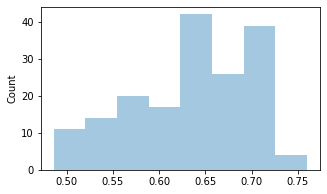

In [168]:
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(predicted_success, kde=False);
a3.set(ylabel='Count')

#### Tidy up data frame

In [170]:
# add predicted restaurant success column to data frame
LA_neigh_sum['predicted_success'] = predicted_success

# change neighborhood column name from Vegan Venue to Borough
LA_neigh_sum.rename(columns={"Vegan Venue": "Borough"}, inplace=True)

LA_neigh_sum.head()

,Borough,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service,predicted_success
0,Adams-Normandie,0,0,9,0,0,5,0.522621
1,Alhambra,9,0,41,0,13,36,0.712062
2,Altadena,1,0,0,0,1,0,0.711954
3,Arcadia,0,0,2,0,0,2,0.689338
4,Arleta,1,0,1,0,0,0,0.711954


In [171]:
## attach latitude and longitude to boroughs/neighborhoods
df_neigh_pred_success = LA_neigh_sum.merge(df_neigh[["Name","lat", "lng"]], left_on='Borough', right_on='Name')

## delete redundant "name" column
del df_neigh_pred_success['Name']
df_neigh_pred_success.head()

,Borough,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service,predicted_success,lat,lng
0,Adams-Normandie,0,0,9,0,0,5,0.522621,34.033081,-118.297115
1,Alhambra,9,0,41,0,13,36,0.712062,34.093042,-118.127060
2,Altadena,1,0,0,0,1,0,0.711954,34.186316,-118.135233
3,Arcadia,0,0,2,0,0,2,0.689338,34.136207,-118.040150
4,Arleta,1,0,1,0,0,0,0.711954,34.241327,-118.432205


#### Plot neighborhoods by how likely they are to support opening of a new restaurant (in their centre)

In [172]:
## Treating all vegan restaurants equally for now, let's explore ratings ... 
# create map 
latitude = 34.0330812
longitude = -118.204865
map_LA_neigh_suitable_for_vegans = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
df = df_neigh_pred_success
for lat, lng, neigh, success in zip(df['lat'], df['lng'], df['Borough'], df['predicted_success']):
    if success > 0.9:
        cur_col = 'green'
    elif success >= 0.8:
        cur_col = '#73cd32'#cdb332
    elif success >= 0.7:
        cur_col = '#9acd32'
    elif success >= 0.6:
        cur_col = '#c1cd32'
    elif success >= 0.5:
        cur_col = 'orange'
    else:
        cur_col = 'red'
    label = '{}'.format(neigh)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=folium.Popup(label, parse_html=True),
        color=cur_col,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_neigh_suitable_for_vegans)  
    
map_LA_neigh_suitable_for_vegans

Which locations are the 5 most promising?

In [174]:
## show dataframe rows for five largest predicted success values
df_neigh_pred_success.nlargest(5, "predicted_success", keep='first')

,Borough,Arts & Entertainment,Bus Stop,Food,Metro Station,Nightlife Spot,Shop & Service,predicted_success,lat,lng
15,Bellflower,0,0,1,0,3,4,0.760003,33.882570,-118.116768
124,Santa Monica,0,0,1,0,4,2,0.760003,34.025072,-118.496513
11,Baldwin Hills/Crenshaw,2,0,4,0,0,15,0.752292,34.023176,-118.334248
64,Granada Hills,3,0,6,0,1,38,0.726966,34.266156,-118.517434
112,Playa del Rey,2,0,2,0,3,6,0.721083,33.955083,-118.436750
